<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>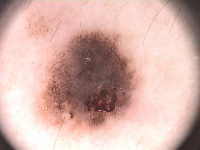</td><td>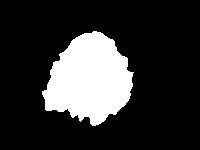</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=4441d0c3-b8d2-4dd4-bb4b-cef4ee415c03
To: /content/PH2Dataset.rar
100% 162M/162M [00:03<00:00, 53.3MB/s]


In [1]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

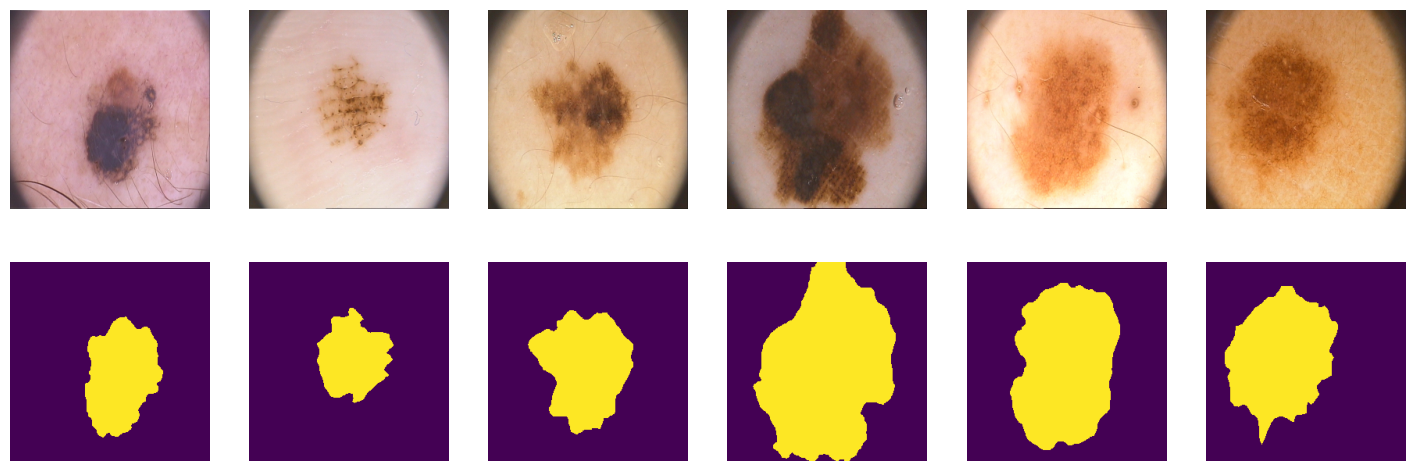

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.9 MB/s eta 0:00:00


In [18]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

Раскроем в тупую формулу BCE:
$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] = $$
$$-\sum_i \left[y_i\log \frac{1}{1+e^{-\hat y_i}} + (1-y_i)\log(1-\frac{1}{1+e^{-\hat y_i}} )\right] = $$
$$-\sum_i \left[-y_i\log ({1+e^{-\hat y_i}}) - \hat y_i - \log ({1+e^{-\hat y_i}}) + y_i \hat y_i + y_i\log ({1+e^{-\hat y_i}}) \right] = $$
$$ + \hat y + \log ({1+e^{-\hat y}}) - y \hat y$$
ЧТД


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [11]:
import torch.nn.functional as F
import torch.nn as nn

In [12]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [13]:
def bce_loss(y_pred, y_real):
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
  return torch.sum(false_bce)

def bce_true(y_pred, y_real):
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))
  return torch.sum(my_bce)

Проверим корректность работы на простом примере

In [14]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 4.0406718254089355
BCE loss честно посчитанный                = 4.0406718254089355
BCE loss from torch bce_torch              = 4.0406718254089355
BCE loss from torch with logits bce_torch  = 4.040672302246094


/tmp/ipython-input-820078199.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
/tmp/ipython-input-820078199.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [15]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

/tmp/ipython-input-820078199.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
/tmp/ipython-input-820078199.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))


Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [16]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 17.332191467285156
BCE loss честно посчитанный               = 17.33219337463379
BCE loss from torch bce_torch             = 17.33219337463379
BCE loss from torch with logits bce_torch = 17.33219337463379


/tmp/ipython-input-820078199.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
/tmp/ipython-input-820078199.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))


In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

/tmp/ipython-input-820078199.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
/tmp/ipython-input-820078199.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))


Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.95MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 7.34MB/s]
Download completed


In [10]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

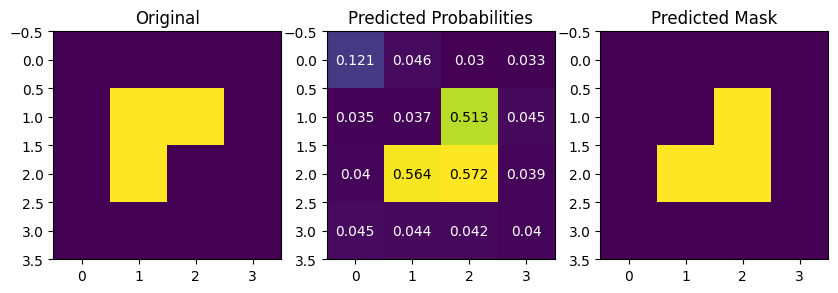

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [20]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

/tmp/ipython-input-820078199.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  false_bce =  y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred))
/tmp/ipython-input-820078199.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_bce = - torch.sum((y_real * np.log(torch.sigmoid(y_pred)) + (1 - y_real) * np.log(1 - torch.sigmoid(y_pred))))


## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

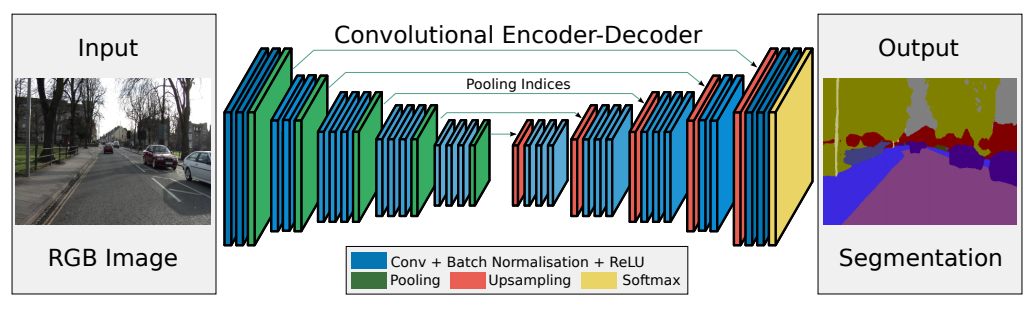

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 135MB/s] 


In [26]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [22]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [23]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
    super(DecoderBlock, self).__init__()
    self.layers = nn.ModuleList()

    self.up = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
    self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
    self.layers.append(nn.BatchNorm2d(out_channels))
    self.layers.append(nn.ReLU(inplace = True))

    for i in range(depth-1):
      self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
      self.layers.append(nn.BatchNorm2d(out_channels))
      self.layers.append(nn.ReLU(inplace = True))
  def forward(self, x, index):
    x = self.up(x, index)
    for i in self.layers:
      x = i(x)
    return x

Соединим блоки энкодера и декодера в модель SegNet:

In [100]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features*2, num_features * 4, depth=3)
        self.encoder3 = EncoderBlock(num_features*4, num_features * 8, depth=3)

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features*8, num_features * 8, depth=3)

        # Decoder bottleneck
        self.decoder0 = DecoderBlock(num_features*8, num_features * 8, depth=3)

        # Decoder
        self.decoder1 = DecoderBlock(num_features*8, num_features*4, depth=3)
        self.decoder2 = DecoderBlock(num_features*4, num_features*2, depth=3)
        self.decoder3 = DecoderBlock(num_features*2, num_features, depth=2)

        self.decoder4 = DecoderBlock(num_features, num_features, depth=2)
        self.final = nn.Conv2d(num_features, out_channels, kernel_size=1)
        # self.sigma = nn.Sigmoid()
    def forward(self, x):
        # encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)
        # TODO
        x = self.decoder0(x, indices4)
        x = self.decoder1(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder3(x, indices1)
        x = self.decoder4(x, indices0)

        output = (self.final(x))
        return output

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [13]:
from tqdm.notebook import tqdm

In [14]:
import torch
import numpy as np

## функции для обучения были взяты из соответствующих семинаров, так как сначала я писал их сам, потом посмотрел в семинаре, мне они понравились больше.

In [15]:
def train_1_epoh(model, optimizer, criterion, train_dataloader, device):
    model.train()
    avg_loss = 0

    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss = avg_loss / len(train_dataloader)
    return model, avg_loss

In [16]:
import matplotlib.patches as mpatches

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def validate_single_epoch(model_segnet, model_classifier, criterion_segnet, criterion_classifier, valid_dataloader, device, plot=False, metric=JaccardIndex, threshold=0.5):

    iou_score = metric(task="binary").to(device)
    model_segnet.eval()
    if model_classifier:
        model_classifier.eval()

    avg_loss_segnet = 0
    avg_loss_classifier = 0 if model_classifier else 0
    avg_iou = 0.0

    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validation"):
            if len(batch) == 3:
                X_batch, Y_emotion_batch, Y_relevance_batch = batch
            elif len(batch) == 2:

                 X_batch, Y_relevance_batch = batch
                 Y_emotion_batch = None

            X_batch = X_batch.to(device)
            if Y_emotion_batch is not None:
                Y_emotion_batch = Y_emotion_batch.to(device)
            Y_relevance_batch = Y_relevance_batch.to(device)
            x_pred = model_segnet(X_batch)
            loss_segnet = criterion_segnet(x_pred, Y_relevance_batch)

            preds_for_iou = (x_pred > threshold).float()
            iou_score.update(preds_for_iou, Y_relevance_batch)
            iou = iou_score.compute()

            avg_loss_segnet += loss_segnet.item()
            avg_iou += iou.item()
            iou_score.reset()

    avg_loss_segnet = avg_loss_segnet / len(valid_dataloader)
    avg_iou = avg_iou / len(valid_dataloader)
    avg_loss_classifier = avg_loss_classifier / len(valid_dataloader) if model_classifier else 0

    if plot:
        clear_output(wait=True)

        fig, axes = plt.subplots(1, 3, figsize=(3*4, 4))

        orig_img = X_batch[0].permute(1,2,0).cpu().numpy()
        true_relevance = Y_relevance_batch[0].squeeze().cpu().numpy()
        pred_relevance_probs = x_pred[0].squeeze().cpu().numpy()
        pred_relevance_binary = preds_for_iou[0].squeeze().cpu().numpy()

        axes[0].imshow(orig_img)
        axes[0].set_title("Original Image")

        im1 = axes[1].imshow(true_relevance, cmap='hot', vmin=0, vmax=1)
        axes[1].set_title("True Relevance Map")
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(pred_relevance_probs, cmap='hot', vmin=0, vmax=1)
        axes[2].set_title(f"Pred Relevance Map (IoU={avg_iou:.3f})")
        plt.colorbar(im2, ax=axes[2])

        plt.tight_layout()
        plt.show()

    return model_segnet, avg_loss_segnet, torch.tensor(avg_iou, device=device)

In [20]:
import os
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path, plot_loss=False):
    total_train_loss = []
    total_val_loss = []
    total_val_iou = []
    os.makedirs(ckpt_path, exist_ok=True)
    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}:')

        model, train_loss = train_1_epoh(model, optimizer, criterion, train_dataloader, device)
        model, val_loss, val_iou = validate_single_epoch(
            model_segnet=model,
            model_classifier=None,
            criterion_segnet=criterion,
            criterion_classifier=None,
            valid_dataloader=valid_dataloader,
            device=device,
            plot=True,
            metric=JaccardIndex,
            threshold=0.5
        )

        print(f'  Train loss: {train_loss:.4f}')
        print(f'  Val loss: {val_loss:.4f}')
        print(f'  Val IoU: {val_iou}')

        total_train_loss.append(train_loss)
        total_val_loss.append(val_loss)
        total_val_iou.append(val_iou.cpu().numpy())

        if plot_loss and (epoch % 5 == 0 or epoch == epochs-1):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            ax1.plot(total_train_loss, label='Train loss')
            ax1.plot(total_val_loss, label='Val loss')
            ax1.set_title("Loss")
            ax1.legend()

            val_iou_array = np.array(total_val_iou)
            for i in range(val_iou_array.shape[1]):
                ax2.plot(val_iou_array[:, i], label=f'Class {i} IoU')
            ax2.set_title("IoU per class")
            ax2.legend()

            plt.tight_layout()
            plt.show()

        # Сохранение лучших моделей
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{ckpt_path}/best_val_loss.pt')
            print(f'  New best val loss: {best_val_loss:.4f}')

        current_mean_iou = val_iou.mean().item()
        if current_mean_iou > best_val_iou:
            best_val_iou = current_mean_iou
            torch.save(model.state_dict(), f'{ckpt_path}/best_val_iou.pt')
            print(f'  New best mean IoU: {best_val_iou:.4f}')

        if epoch % 10 == 0:
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}.pt')

    statistics = {
        'train_loss': total_train_loss,
        'val_loss': total_val_loss,
        'val_iou': total_val_iou
    }

    return model, statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [43]:
model  = SegNet()

In [44]:
# device = 'cpu'
model.to(device)

SegNet(
  (encoder0): EncoderBlock(
    (layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (maxpooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder1): EncoderBlock(
    (layers): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU

In [45]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [49]:
epochs = 5
ckpt_path = '/content/checkpoints'

Модель была обучена сначала на 20 эпохах, я очень долго думал, где же ошибка, оказывается она просто очень долго сходится, поэтому потом решил дообучить еще на 5 эпохах, результат можно видеть ниже

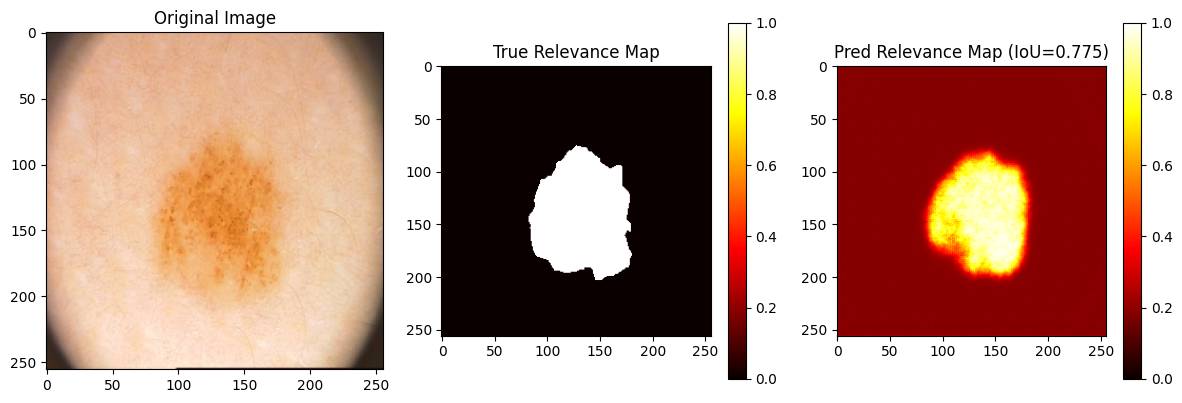

  Train loss: 0.2174
  Val loss: 0.2850
  Val IoU: 0.7753628492355347


In [50]:
model, statistic = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

In [51]:
statistic

{'train_loss': [0.25793077424168587,
  0.23617396131157875,
  0.22855355590581894,
  0.22602438554167747,
  0.217381801456213],
 'val_loss': [0.33684635162353516,
  0.3394213020801544,
  0.2732533812522888,
  0.2942488342523575,
  0.284979872405529],
 'val_iou': [array(0.6978718, dtype=float32),
  array(0.69959146, dtype=float32),
  array(0.7859354, dtype=float32),
  array(0.7754148, dtype=float32),
  array(0.77536285, dtype=float32)]}

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [68]:
def test(model, valid_dataloader, ckpt_path, device, criterion, metric):
    model.to(device)
    model.eval()
    iou_score = metric(task="binary").to(device)
    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          loss = criterion(Y_pred, Y_batch)

          Y_pred_softmax = torch.softmax(Y_pred, dim=1)
          iou = iou_score(Y_pred_softmax, Y_batch)

          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)
    return model, avg_loss, 1 -  avg_iou

In [69]:
model, avg_loss, avg_iou = test(model, valid_dataloader, ckpt_path, device, criterion, metric = JaccardIndex)

100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


In [70]:
avg_loss

tensor(0.2850, device='cuda:0')

In [71]:
avg_iou

tensor(0.6907, device='cuda:0')

Написал свой test, потом подумал и решил что за меня все сделали в семинаре, поэтому можно просто их функцией восопльзоваться

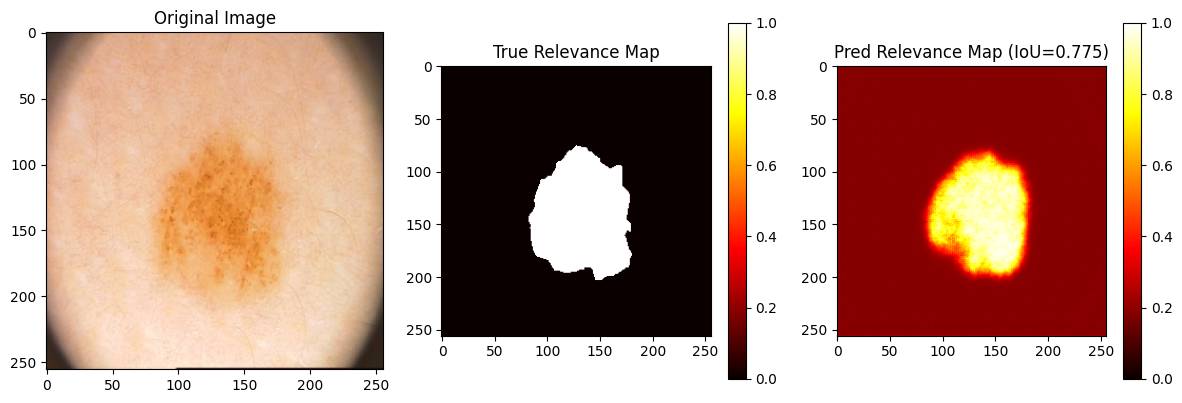

In [57]:
model, val_loss, val_iou = validate_single_epoch(
            model_segnet=model,
            model_classifier=None,
            criterion_segnet=criterion,
            criterion_classifier=None,
            valid_dataloader=valid_dataloader,
            device=device,
            plot=True,
            metric=JaccardIndex,
            threshold=0.5
)

In [60]:
val_loss

0.284979872405529

In [61]:
val_iou

tensor(0.7754, device='cuda:0')

Как видно лучший показатель 77.54%

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [72]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    p = torch.softmax(logits, dim = 1)
    pred = (p > threshold).float()
    tp = torch.sum(p*labels)
    fp = torch.sum(p) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8
    score = (2*tp + eps)/ (2 * tp + fn + fp + eps)
    return score

Проверим на корректность функцию dice_score:

In [73]:
pip install torchmetrics

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
from torchmetrics.segmentation import DiceScore
dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.3158, device='cuda:0')

In [76]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

"\nесли вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():\n\nfrom torchmetrics.classification import Dice\n\ndice = Dice(average='micro').to(device)\n\n"

In [77]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.3158, device='cuda:0')

In [78]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [79]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    p = torch.sigmoid(logits)

    tp = torch.sum(p * labels)
    fp = torch.sum(p) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    loss = 1 - dice

    return loss

Проверка на корректность:

In [80]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00


In [81]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [82]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [83]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [84]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # TODO
    loss = -torch.sum((1 -(torch.sigmoid(y_pred)*y_real + (1- torch.sigmoid(y_pred))*(1 - y_real)))**gamma  * (y_real * torch.log(torch.sigmoid(y_pred+eps)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + eps)))

    return loss

Проверка корректности функции:

In [85]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [86]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161, device='cuda:0')

In [87]:
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'), focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0), rtol=1e-5, atol=1e-8)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [88]:
def loss_facial(sposob='fully supervised', x_target=None, x_pred=None, lambda_fp=None, gamma=None):
    if sposob == 'fully supervised':
        return torch.mean((x_target - x_pred) ** 2)

    if sposob == 'weakly supervised':
        spatial_dims = x_pred.shape[-2:]
        m, n = spatial_dims[0], spatial_dims[1]
        L_sparsity = torch.sum(torch.abs(x_pred), dim=(-2, -1)).mean() / (m * n)
        diff_i = x_pred[..., 1:, :] - x_pred[..., :-1, :]
        diff_j = x_pred[..., :, 1:] - x_pred[..., :, :-1]

        sum_diff_i = torch.sum(torch.abs(diff_i), dim=(-2, -1))
        sum_diff_j = torch.sum(torch.abs(diff_j), dim=(-2, -1))
        L_contiguity = ((sum_diff_i + sum_diff_j).mean() / (m * n))
        return L_sparsity + gamma * L_contiguity


def loss_article(predictions, targets, x_target=None, x_pred=None, lambda_global=1.0, gamma_ws=0.1, facial_loss_method='fully supervised'):
    predictions_clamped = torch.clamp(predictions, min=1e-8)
    L_classification = -torch.sum(targets * torch.log(predictions_clamped))
    L_facial_parts = loss_facial(
        sposob=facial_loss_method,
        x_target=x_target,
        x_pred=x_pred,
        gamma=gamma_ws
    )
    return L_classification + lambda_global * L_facial_parts


## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



DiceLoss

In [101]:
model  = SegNet().to(device)

In [102]:
criterion = DiceLoss(mode='binary').to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [103]:
ckpt_path =  '/content/checkpoints_dice'

In [104]:
epochs = 25

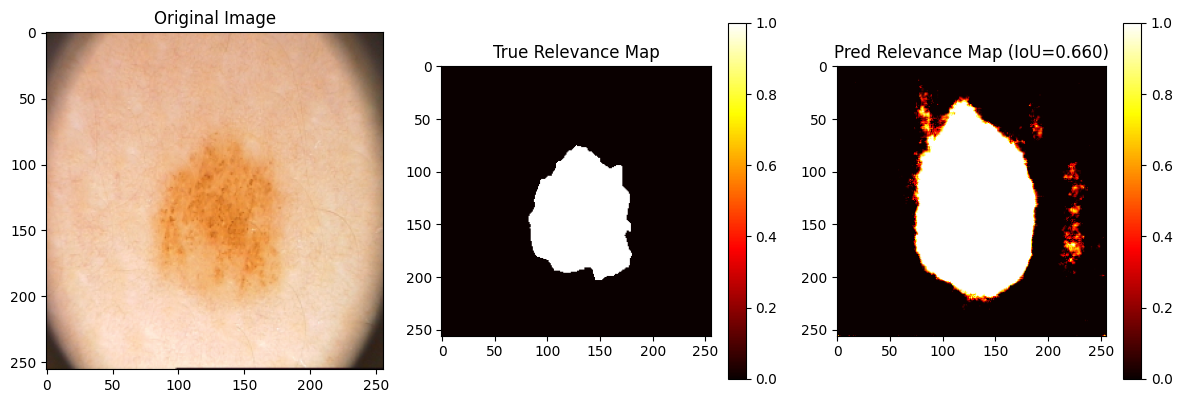

  Train loss: 0.2054
  Val loss: 0.3638
  Val IoU: 0.6596153974533081


In [105]:
model, statistics = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

In [106]:
statistics

{'train_loss': [0.6029033958911896,
  0.5862480998039246,
  0.5617528706789017,
  0.5280613750219345,
  0.4834028482437134,
  0.4308305084705353,
  0.379952996969223,
  0.34013229608535767,
  0.3117274343967438,
  0.30243881046772003,
  0.29882632195949554,
  0.26900550723075867,
  0.2689775228500366,
  0.25628767907619476,
  0.2487284243106842,
  0.2502474784851074,
  0.24401791393756866,
  0.24023215472698212,
  0.2421235293149948,
  0.2541038244962692,
  0.23957647383213043,
  0.22482939064502716,
  0.23179814219474792,
  0.2108185887336731,
  0.2053663730621338],
 'val_loss': [0.6281038224697113,
  0.6250822842121124,
  0.6206701397895813,
  0.613131582736969,
  0.6009088158607483,
  0.5860024988651276,
  0.5715266168117523,
  0.5604017972946167,
  0.5514775216579437,
  0.5451772511005402,
  0.5305474400520325,
  0.4908178150653839,
  0.517094612121582,
  0.45929181575775146,
  0.4182741940021515,
  0.4343147575855255,
  0.4399087727069855,
  0.3362443745136261,
  0.402648448944091

Как видно лучший показатель 72%

Focal

In [107]:
model  = SegNet().to(device)

In [109]:
def focal_loss_fn(y_pred, y):
    loss = sigmoid_focal_loss(
        inputs=y_pred,
        targets=y,
        gamma=2.0,
        reduction='sum'
    )
    return loss

criterion = focal_loss_fn

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [110]:
ckpt_path =  '/content/checkpoints_focal'

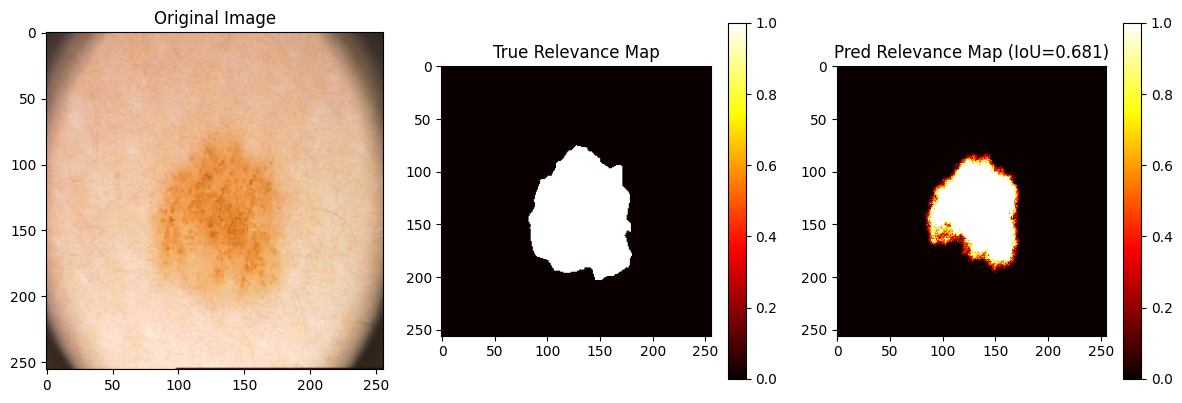

  Train loss: 26306.8711
  Val loss: 28915.6328
  Val IoU: 0.6807973384857178
  New best val loss: 28915.6328


In [112]:
model, train_losses = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

In [116]:
np.array(statistics['val_iou']).max()

np.float32(0.7856885)

Как видно, при focal_loss = модель показала результат 78.5%, что лучше чем у любой другой модели, но после этого началось переобучение.

# Задание: Новая модель!

# !!! Написал 2 U_net, 1 с unpool другой с convtrans, чтобы попрактиковаться.

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

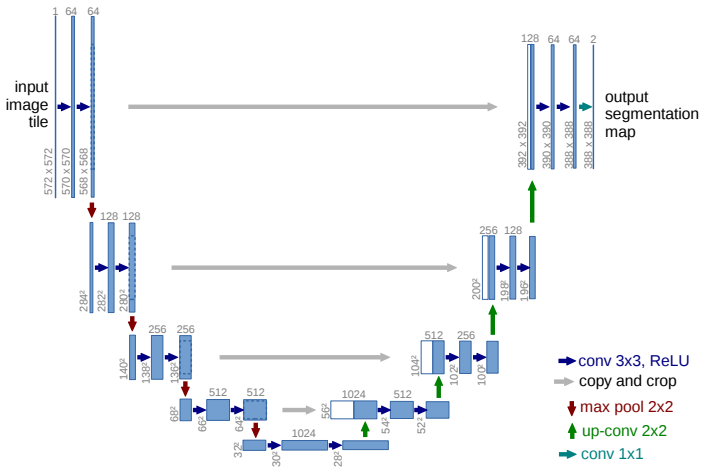

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [117]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [45]:
class UNet_changed(nn.Module):
    def __init__(self, n_class=1, in_channels=3, num_features=64): # Пример: in_channels=3 для RGB
        super().__init__()

        # Encoder
        self.enc1_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc1_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc2_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc3_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc4_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc4_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.enc5_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc5_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*16, out_channels=num_features*16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        #decoder
        self.upconv4 = nn.Conv2d(num_features*16, num_features*8, kernel_size=1)
        self.maxun1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec1_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8 + num_features*8, out_channels=num_features*8, kernel_size=3, padding=1), # 512 + 512 -> 512
            nn.ReLU(inplace=True)
        )
        self.dec1_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.Conv2d(num_features*8, num_features*4, kernel_size=1)
        self.maxun2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec2_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4 + num_features*4, out_channels=num_features*4, kernel_size=3, padding=1), # 256 + 256 -> 256
            nn.ReLU(inplace=True)
        )
        self.dec2_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.Conv2d(num_features*4, num_features*2, kernel_size=1)
        self.maxun3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec3_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2 + num_features*2, out_channels=num_features*2, kernel_size=3, padding=1), # 128 + 128 -> 128
            nn.ReLU(inplace=True)
        )
        self.dec3_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.Conv2d(num_features*2, num_features, kernel_size=1)
        self.maxun4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec4_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features + num_features, out_channels=num_features, kernel_size=3, padding=1), # 64 + 64 -> 64
            nn.ReLU(inplace=True)
        )
        self.dec4_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final = nn.Conv2d(in_channels=num_features, out_channels=n_class, kernel_size=1)
        self.sigma = nn.Sigmoid()
    def forward(self, x):
        # Encoder
        e1 = self.enc1_1(x)
        e1 = self.enc1_2(e1)
        e1_pool, ind1 = self.max1(e1)

        e2 = self.enc2_1(e1_pool)
        e2 = self.enc2_2(e2)
        e2_pool, ind2 = self.max2(e2)

        e3 = self.enc3_1(e2_pool)
        e3 = self.enc3_2(e3)
        e3_pool, ind3 = self.max3(e3)

        e4 = self.enc4_1(e3_pool)
        e4 = self.enc4_2(e4)
        e4_pool, ind4 = self.max4(e4)

        # Bottleneck
        e5 = self.enc5_1(e4_pool)
        e5 = self.enc5_2(e5)

        # Decoder

        d1 = self.upconv4(e5)
        d1 = self.maxun1(d1, ind4)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.dec1_1(d1)
        d1 = self.dec1_2(d1)

        d2 = self.upconv3(d1)
        d2 = self.maxun2(d2, ind3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2_1(d2)
        d2 = self.dec2_2(d2)

        d3 = self.upconv2(d2)
        d3 = self.maxun3(d3, ind2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3_1(d3)
        d3 = self.dec3_2(d3)

        d4 = self.upconv1(d3)
        d4 = self.maxun4(d4, ind1)
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.dec4_1(d4)
        d4 = self.dec4_2(d4)

        output = self.final(d4)
        output = self.sigma(output)
        return output

In [46]:
class UNet(nn.Module):
    def __init__(self, n_class=1, in_channels=3, num_features=64):
        super().__init__()

        # Encoder
        self.enc1_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc1_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc2_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc4_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.enc5_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc5_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*16, out_channels=num_features*16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up4 = nn.ConvTranspose2d(num_features*16, num_features*8, kernel_size=2, stride=2)
        self.dec1_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*16, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec1_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(num_features*8, num_features*4, kernel_size=2, stride=2)
        self.dec2_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*8, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec2_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(num_features*4, num_features*2, kernel_size=2, stride=2)
        self.dec3_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec3_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(num_features*2, num_features, kernel_size=2, stride=2)
        self.dec4_1 = nn.Sequential(
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec4_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final = nn.Conv2d(in_channels=num_features, out_channels=n_class, kernel_size=1)
        self.sigma = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1_1(x)
        e1 = self.enc1_2(e1)
        e1_pool = self.max1(e1)

        e2 = self.enc2_1(e1_pool)
        e2 = self.enc2_2(e2)
        e2_pool = self.max2(e2)

        e3 = self.enc3_1(e2_pool)
        e3 = self.enc3_2(e3)
        e3_pool = self.max3(e3)

        e4 = self.enc4_1(e3_pool)
        e4 = self.enc4_2(e4)
        e4_pool = self.max4(e4)

        # Bottleneck
        e5 = self.enc5_1(e4_pool)
        e5 = self.enc5_2(e5)

        # Decoder
        d1 = self.up4(e5)
        d1 = torch.cat([d1, e4], dim=1)
        d1 = self.dec1_1(d1)
        d1 = self.dec1_2(d1)

        d2 = self.up3(d1)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2_1(d2)
        d2 = self.dec2_2(d2)

        d3 = self.up2(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3_1(d3)
        d3 = self.dec3_2(d3)

        d4 = self.up1(d3)
        d4 = torch.cat([d4, e1], dim=1)
        d4 = self.dec4_1(d4)
        d4 = self.dec4_2(d4)

        output = self.final(d4)
        output = self.sigma(output)
        return output

In [47]:
unet_model = UNet().to('cpu')

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



BCE

In [40]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    unet_model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [25]:
ckpt_path =  '/content/checkpoints_bce_unet'

In [27]:
epochs = 5
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [43]:
model, statistics = train(unet_model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, 'cpu', ckpt_path)

Epoch 1/5:


  0%|          | 0/4 [00:00<?, ?it/s]

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Dice

In [ ]:
unet_model = UNet().to(device)

In [ ]:
criterion = DiceLoss(mode='binary').to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [ ]:
ckpt_path =  '/content/checkpoints_dice_unet'

In [ ]:
model, train_losses, val_losses = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Focal

In [ ]:
unet_model = UNet().to(device)

In [ ]:
def focal_loss_fn(y_pred, y):
    loss = sigmoid_focal_loss(
        inputs=y_pred,
        targets=y,
        gamma=2.0,
        reduction='sum'
    )
    return loss

criterion = focal_loss_fn

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

In [ ]:
ckpt_path =  '/content/checkpoints_focal_unet'

In [ ]:
model, train_losses, val_losses = train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, ckpt_path)

Как можно видеть, результаты очень похожие, следовательно лучшей метрикой лучше брать BCELoss, так как на данный момент, насколько я знаю она самая надежная и простая в использовании.